In [27]:
import numpy as np
import os
from scipy.linalg import solve
from scipy.signal import lfilter

from lpc.coding import Encoder, Decoder
from lpc.utils import dump_audio, get_audio
from utils import butter_lowpass_filter, plot, plot_audio

fs = 44100
window_len = int(240 / 8000 * fs)
window_step = int(180 / 8000 * fs)
bt_min_f, bt_max_f = 100, 400

Here we put together all the steps performed in **vocal_source_estimation** and **vocal_tract_estimation** notebooks and add some more. We first perform encoding of arbitrarily chosen speech frame and then decode it. _Encoder_ and _Decoder_ classes from _lpc.coding_ package perform these exact steps in a loop for entire signal. They are written in Cython - partially for practice and partially due to Python being slow when it comes to making function calls in loops.

First let's read in some 'a' vowel. We lowpass filter the signal to simulate sampling at 8000Hz (we could actually sample it at 8000Hz but won't go back now).

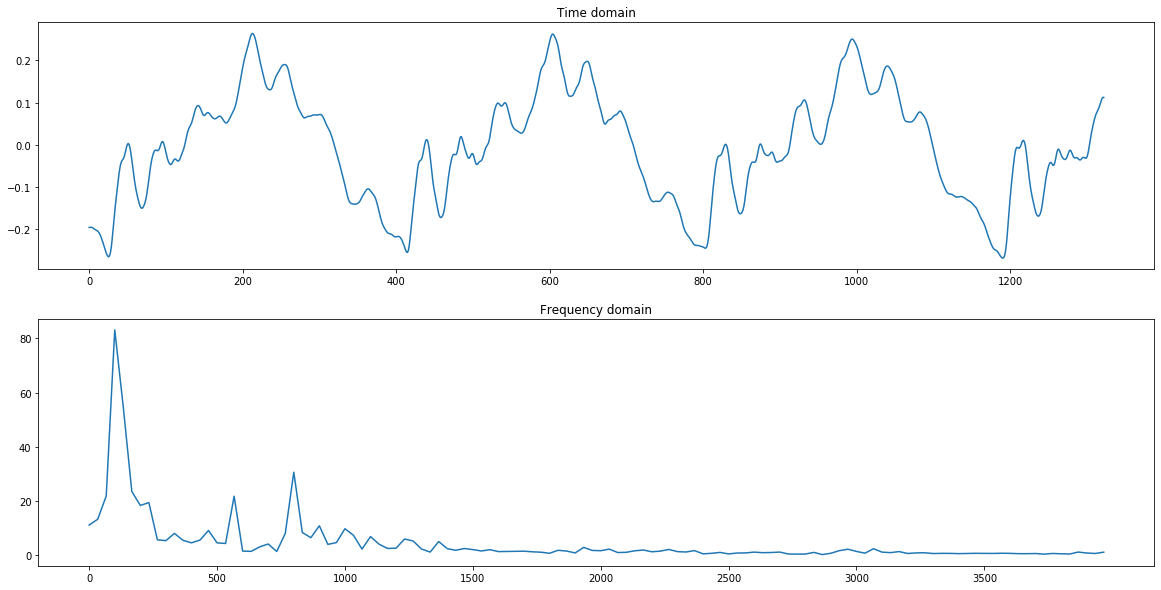

In [28]:
audio_dir = os.path.join('.', '..', 'audio')
audio = get_audio(os.path.join(audio_dir, 'a.wav'))
left = audio[:, 0].astype(np.double)
a_lp = butter_lowpass_filter(left, 4000, sample_rate=fs)

offset = 40000
window_audio = a_lp[offset:offset + window_len]

plot_audio(window_audio)

# Compression

### 1. Preemphasis
We first apply simple FIR filter to input signal. The purpose is to enhance high frequencies in the speech signal so they're not lost in compression.

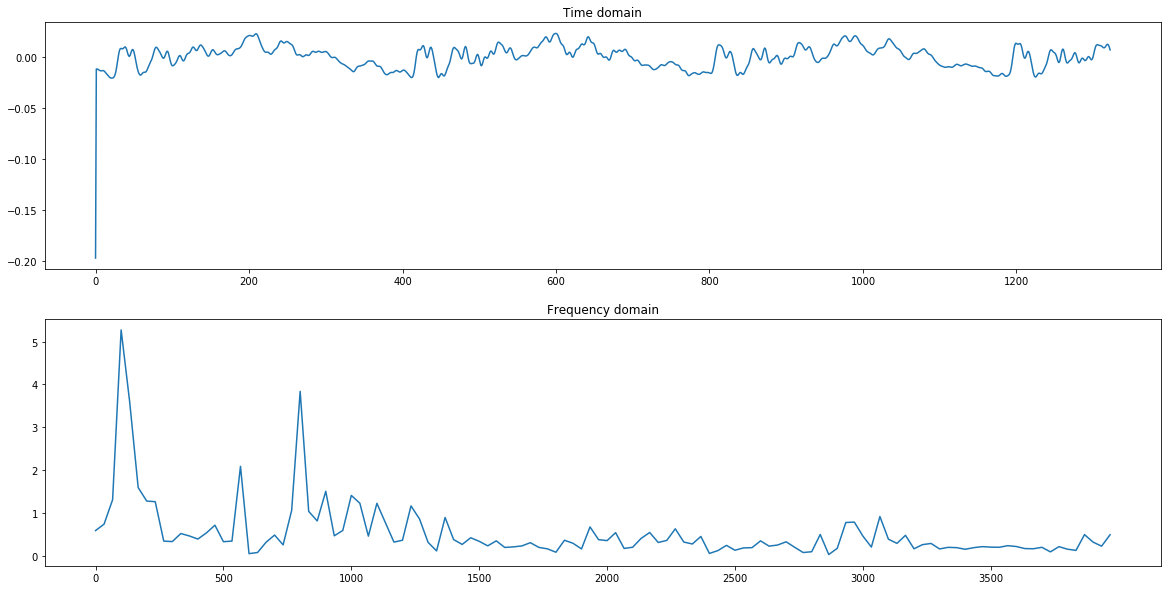

In [29]:
preemp_audio = np.convolve(window_audio, np.array([1.0, -0.9375]), mode='same')
plot_audio(preemp_audio)

### 2. Hamming window.
Next up we multiply the signal by Hamming window. This is done because without it all the frequency analysis we perform is done for signal multiplied by a rectangular window. Frequency response of a rectangular filter is a sinc function and it is convolved with the original spectrum, disturbing it. It would be perfect if we could have a window function with Dirac delta frequency response, because it would not change original signal at all after convolution. 

But that we cannot have, so we use approximations, one of which is a Hamming window.

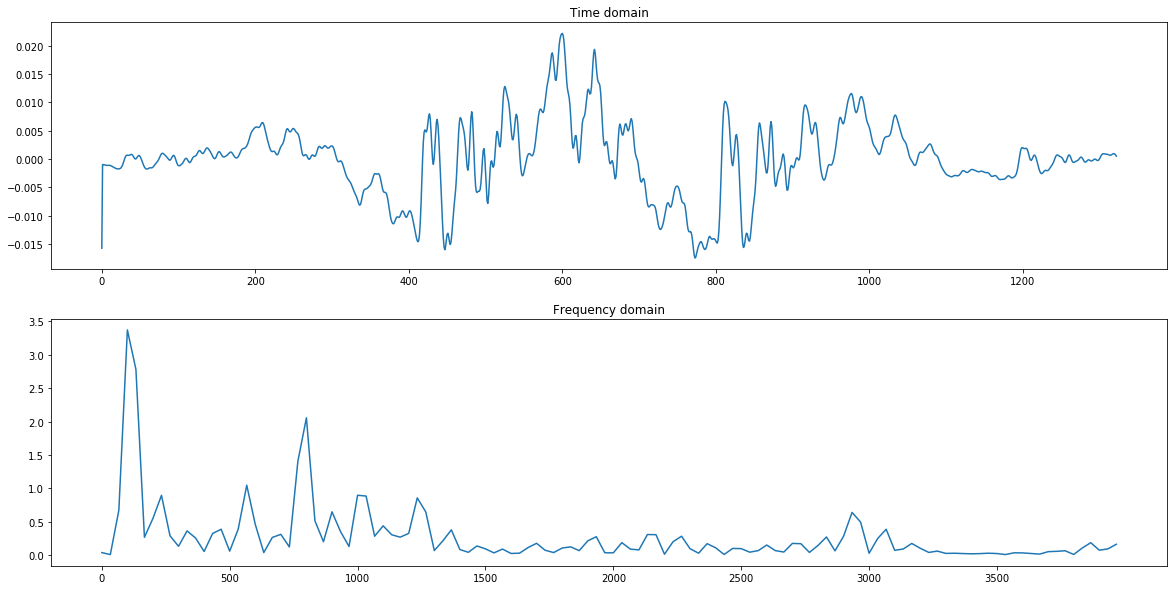

In [30]:
hamming = np.hamming(window_len)
h_audio = preemp_audio * hamming
plot_audio(h_audio)

### 3. Vocal filter parameters.
Now we estimate the parameters of the vocal tract filter. We model it as and order 10 IIR filter.

In [31]:
n_coef = 10

def find_coef(arr):
    r_arr = np.correlate(arr, arr, mode='same')
    r_arr = r_arr[len(r_arr) // 2:]
    
    r_matrix = np.empty((n_coef, n_coef))
    for i in range(n_coef):
        r_matrix[i, i:] = r_arr[:n_coef - i]
        r_matrix[i, :i] = r_arr[i:0:-1]
        
    coef = solve(r_matrix, -r_arr[1:n_coef + 1], assume_a='sym')
    G = r_arr[0] + np.dot(r_arr[1:n_coef + 1], coef)
    
    b = np.array([G])
    a = np.concatenate([np.array([1]), coef])

    return b, a

In [32]:
b, a = find_coef(h_audio)

### 4. Base tone estimation.
In this step we estimate the base tone of given sound (or determine that it's unvoiced). We accomplish this in several steps:
  * lowpass filter with 900Hz cutoff
  * determine base tone period using autocorrelation function
  
Thresholding is suggested after the lowpass too, but it really did not help for this particular sound. 

In [33]:
lp_audio = butter_lowpass_filter(h_audio, 900, sample_rate=fs)

In [34]:
corr = np.correlate(lp_audio, lp_audio, mode='same')
corr = corr[len(corr) // 2:]

In [35]:
bt_max_s = int(fs / bt_min_f)
bt_min_s = int(fs / bt_max_f)

def find_period(corr):
    max_ind = np.argmax(corr[bt_min_s:bt_max_s])
    if corr[bt_min_s + max_ind] > 0.35 * corr[0]:
        return (max_ind + bt_min_s) / fs
    else:
        return 0  # well, works most of the time...
    
base_period = find_period(corr)

In [36]:
'Period {:.6f}s <-> Frequency {:.2f}Hz'.format(base_period, 1 / base_period)

'Period 0.008844s <-> Frequency 113.08Hz'

# Decompression

### 1. Signal synthesis.
Here we simply produce the base tone signal based on base tone frequency. For voiced sounds we model it as series of Dirac deltas with offset given by base tone period. For unvoiced ones we use uniform random noise.

In [37]:
if base_period < 1e-5:
    base_tone = 2 * (np.random.uniform(size=window_step) - 0.5)
else:
    base_tone_offset = int(base_period * fs)
    base_tone = np.zeros(window_step)
    base_tone[::base_tone_offset] = 1
    
audio_decomp = lfilter(b, a, base_tone)

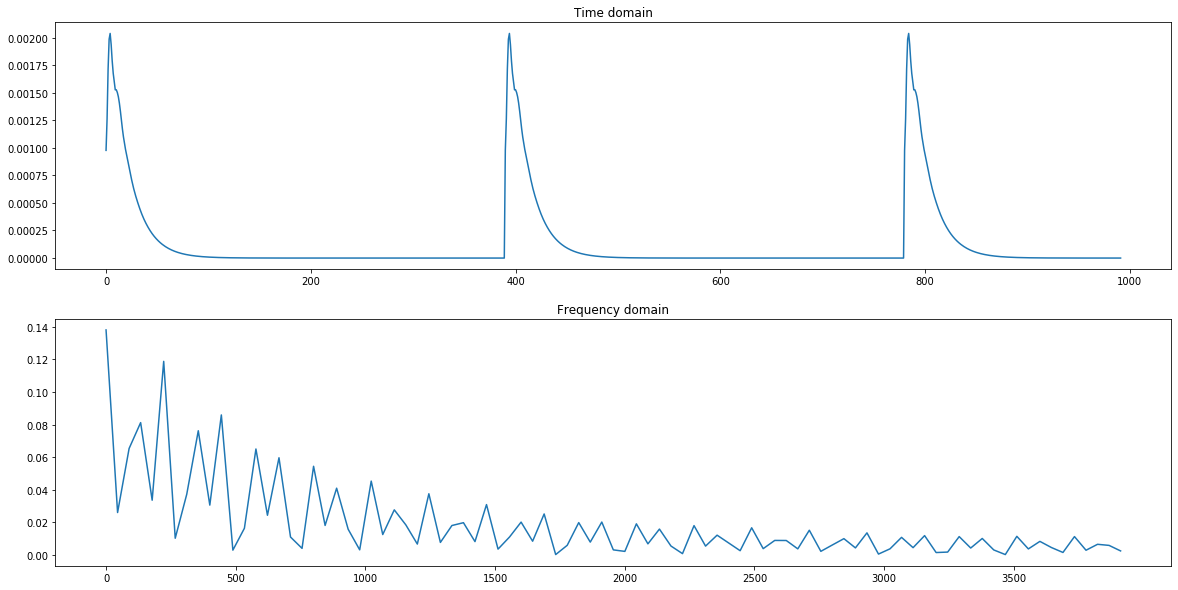

In [38]:
plot_audio(audio_decomp)

### 2. Deemphasis.
Here we apply an IIR filter inverse to preemphasis FIR filter applied before. 

In [39]:
deemp_audio = lfilter([1], [1, -0.9375], audio_decomp)

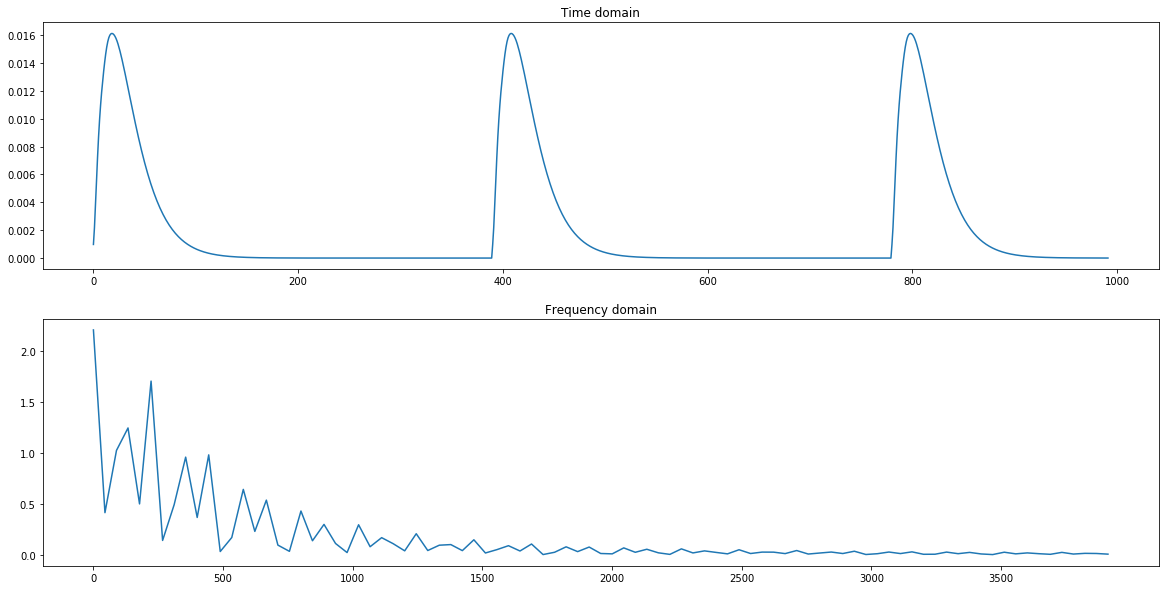

In [40]:
plot_audio(deemp_audio)

So that's the outline of the steps. For a single audio frame of 30ms it looks pretty bad both time- and frequency-wise. It shall be more interesting to actually listen to the results obtained for a couple of seconds of recorded speech.

Here's the result of using encoder and decoder from *lpc.coding* package. 

In [41]:
enc = Encoder(window_len, window_step, 10, bt_min_f, bt_max_f, fs)
compressed = enc.encode(window_audio)

In [42]:
dec = Decoder(window_step, 10)
decompressed = dec.decode(compressed)

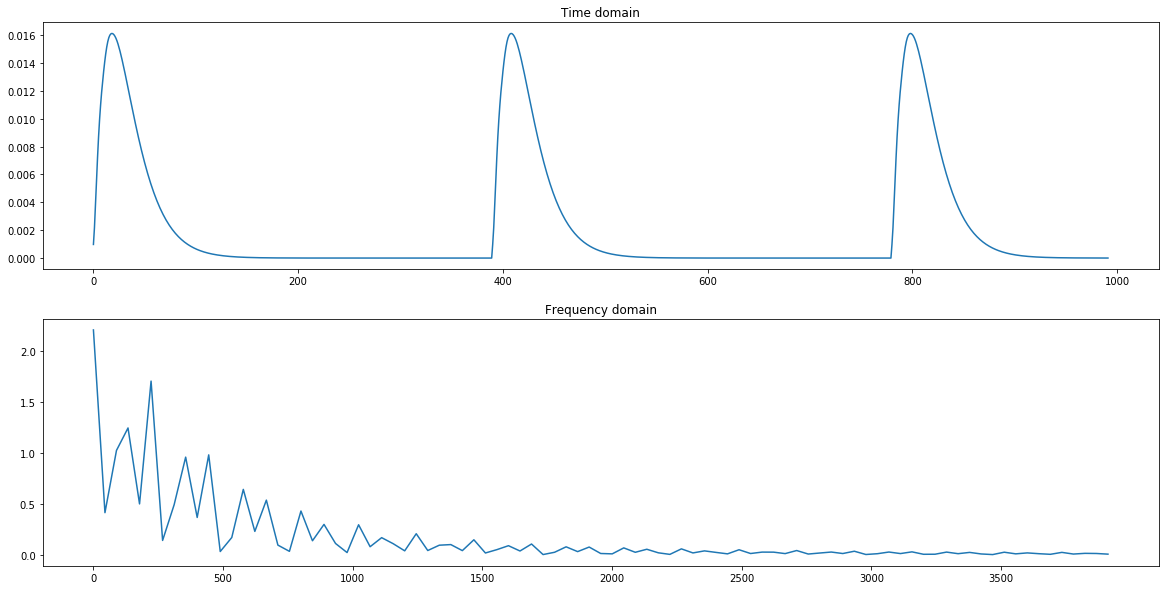

In [43]:
plot_audio(deemp_audio)

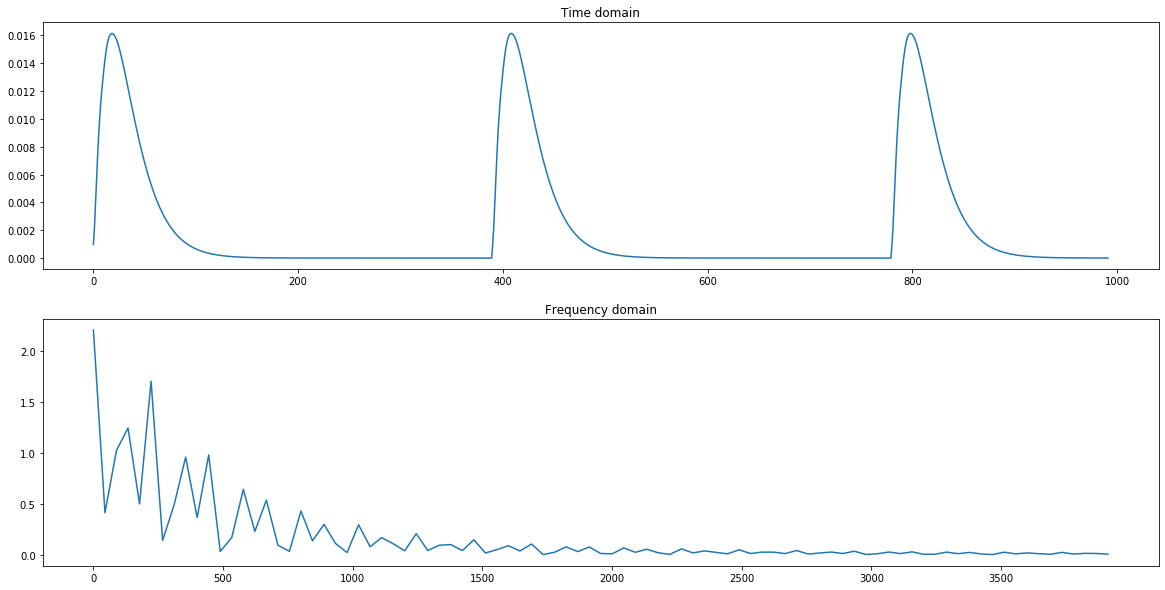

In [44]:
plot_audio(decompressed)

Cool :D Lessons learned: 
  * _cygdb_ is a life-saver
  * when using LAPACK - read goddamn docs and allocate memory if necessary
  * in the future - debug every step instead of everythin 